In [1]:
# Impordid
import os
import numpy as np
from collections import defaultdict

# Korpuse lugemiseks
from estnltk.converters.conll import conll_importer

import matplotlib.pyplot as plt

In [2]:
def get_dataset_paths(dataset):
    dataset_dir = os.path.join('data', dataset)
    files = os.listdir(dataset_dir)
    
    paths = {}
    for split in ['train', 'dev', 'test']:
        matching_file = next(f for f in files if f'-ud-{split}.' in f)
        paths[split] = os.path.join(dataset_dir, matching_file)
    
    return paths

edt = get_dataset_paths('edt')
ewt = get_dataset_paths('ewt')
print(edt)
print(ewt)

{'train': 'data\\edt\\et_edt-ud-train.conllu', 'dev': 'data\\edt\\et_edt-ud-dev.conllu', 'test': 'data\\edt\\et_edt-ud-test.conllu'}
{'train': 'data\\ewt\\et_ewt-ud-train.conllu', 'dev': 'data\\ewt\\et_ewt-ud-dev.conllu', 'test': 'data\\ewt\\et_ewt-ud-test.conllu'}


In [4]:
def preprocess(dataset_path):
    dataset = conll_importer.conll_to_text(file=dataset_path)
    parsed_sents = []
    stats = {
        'words': 0,
        'sentences': 0
    }
    for sent in dataset.sentences:
        parsed_sent = []
        stats['sentences'] += 1
        for word, misc in zip(sent.words, sent.conll_syntax.misc):
            tag = 'O'
            if misc:
                if 'NE' in misc:
                    tag = misc['NE']
            pair = (word.text.lower(), tag)
            stats['words'] += 1
            stats[tag] = stats.get(tag, 0) + 1
            #print(f"({word.text}, {tag})")
            parsed_sent.append(pair)
        parsed_sents.append(parsed_sent)
        
    return parsed_sents, stats            

In [5]:
ewt_dev_sents, ewt_dev_stats = preprocess(ewt['dev'])
ewt_train_sents, ewt_train_stats = preprocess(ewt['train'])
ewt_test_sents, ewt_test_stats = preprocess(ewt['test'])

In [6]:
edt_dev_sents, edt_dev_stats = preprocess(edt['dev'])
edt_train_sents, edt_train_stats = preprocess(edt['train'])
edt_test_sents, edt_test_stats = preprocess(edt['test'])

In [7]:
ewt_stats = {
    'dev' : ewt_dev_stats,
    'train' : ewt_train_stats,
    'test' : ewt_test_stats
}
edt_stats = {
    'dev' : edt_dev_stats,
    'train' : edt_train_stats,
    'test' : edt_test_stats
}

def plot_stats(stats, name):
  word_counts = [stats[split]['words'] for split in ['dev', 'train', 'test']]
  sent_counts = [stats[split]['sentences'] for split in ['dev', 'train', 'test']]

  splits = ['Dev', 'Train', 'Test']
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

  bars1 = ax1.bar(splits, word_counts, color='steelblue')
  ax1.set_title(f'Sõnade arv {name} andmestikus')
  ax1.set_ylabel('Sõnu')

  bars2 = ax2.bar(splits, sent_counts, color='darkgreen')
  ax2.set_title(f'Lausete arv {name} andmestikus')
  ax2.set_ylabel('Lauseid')

  def autolabel(ax, rects):
      for rect in rects:
          height = rect.get_height()
          ax.annotate(f'{int(height):,}',
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 0),
                      textcoords="offset points",
                      ha='center', va='bottom')

  autolabel(ax1, bars1)
  autolabel(ax2, bars2)

  plt.tight_layout()
  plt.show()

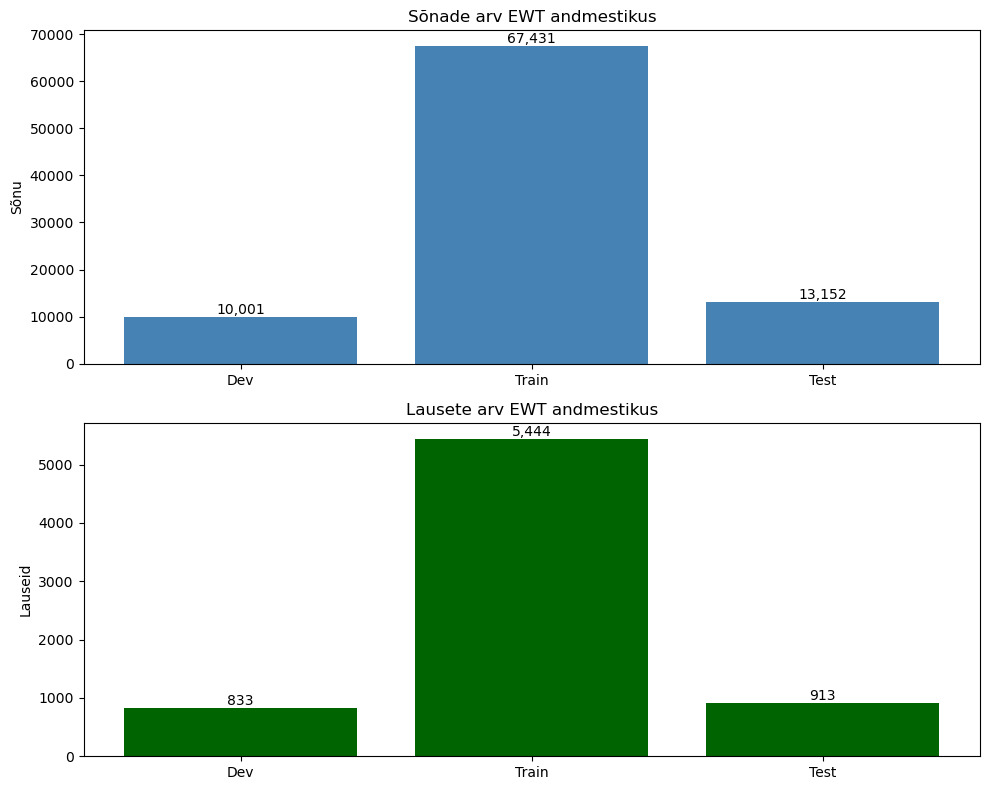

In [8]:
plot_stats(ewt_stats, 'EWT')

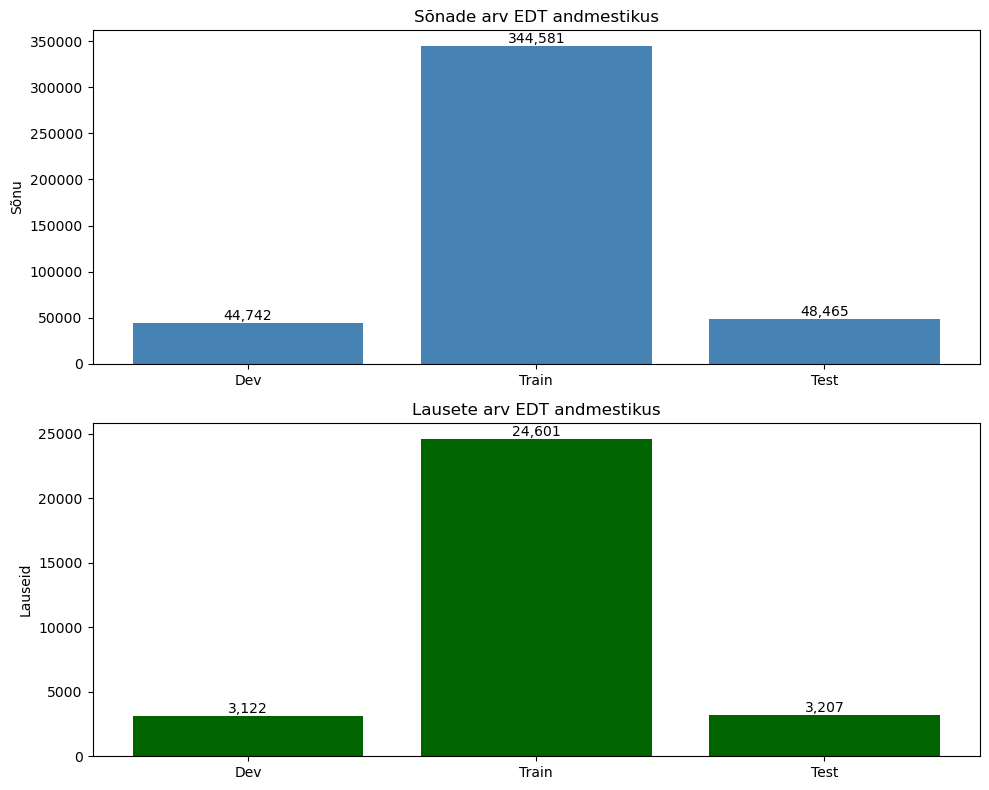

In [9]:
plot_stats(edt_stats, 'EDT')

In [16]:
def plot_tag_distribution(stats_dict, name, split_name):
    tag_counts = {k: v for k, v in stats_dict.items() 
                 if k not in ['words', 'sentences']}
    
    sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Ei arvesta "O"
    non_o_tags = [(tag, count) for tag, count in sorted_tags if tag != 'O']
    if non_o_tags:
        tags_no_o, counts_no_o = zip(*non_o_tags)
        fig, ax = plt.subplots(figsize=(12, 5))
        bars = ax.bar(tags_no_o, counts_no_o, color='darkgreen')
        ax.set_title(f'Märgendite jaotus {name} {split_name} hulgas (ei arvesta "O")')
        ax.set_ylabel('Arv')
        ax.tick_params(axis='x', rotation=45)
        
        # Väärtused
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}',
                   ha='center', va='bottom')
    
    plt.tight_layout()
    return fig

def plot_tag_distribution_all_splits(stats, name):
  for split in ['dev', 'train', 'test']:
      fig = plot_tag_distribution(stats[split], name, split.capitalize())
      plt.show()

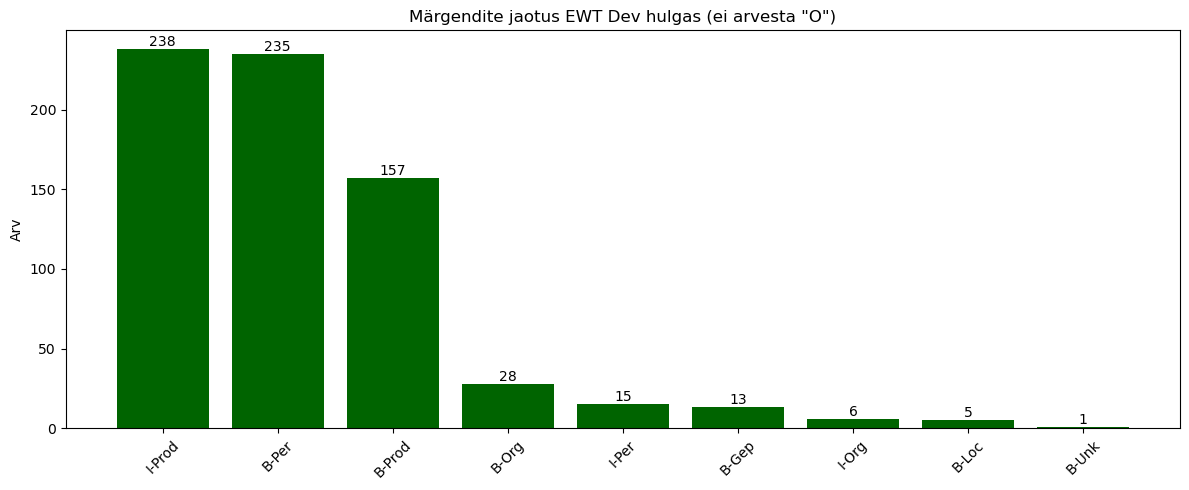

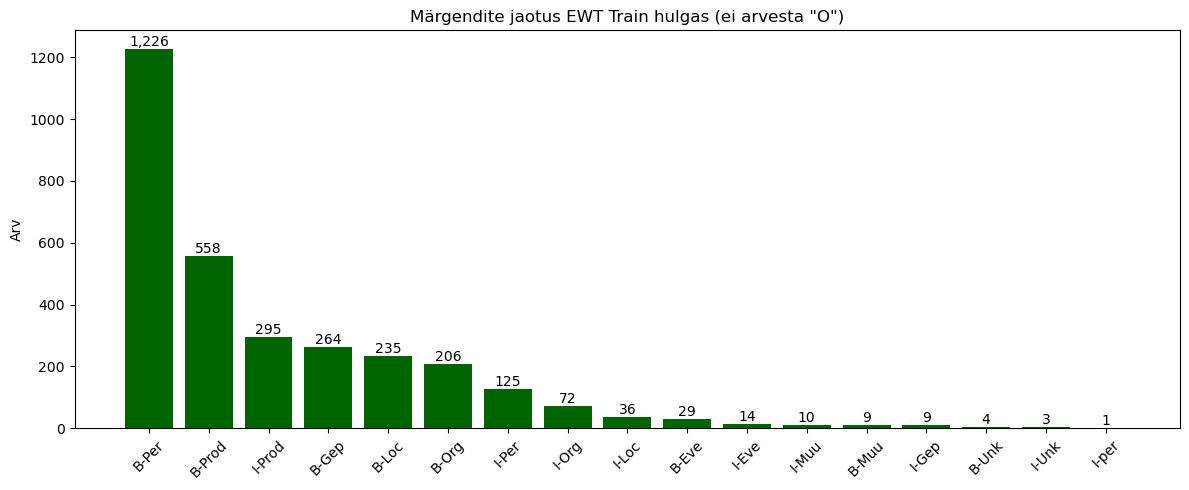

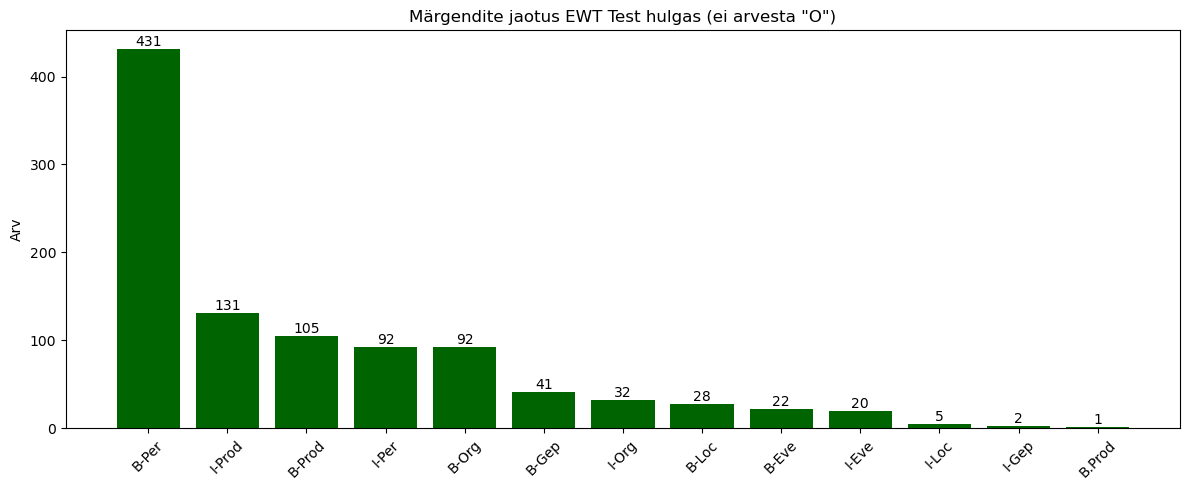

In [17]:
plot_tag_distribution_all_splits(ewt_stats, 'EWT')

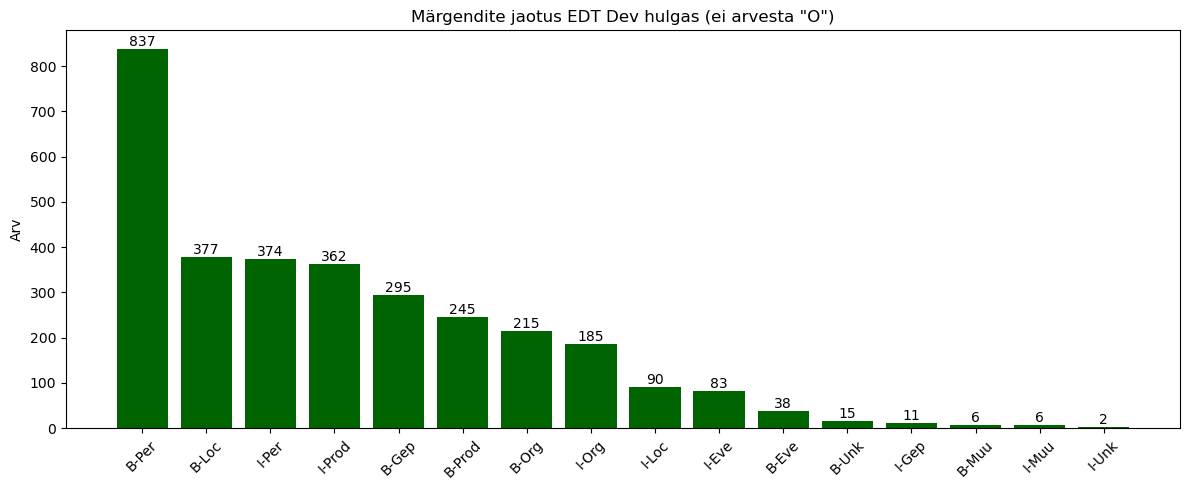

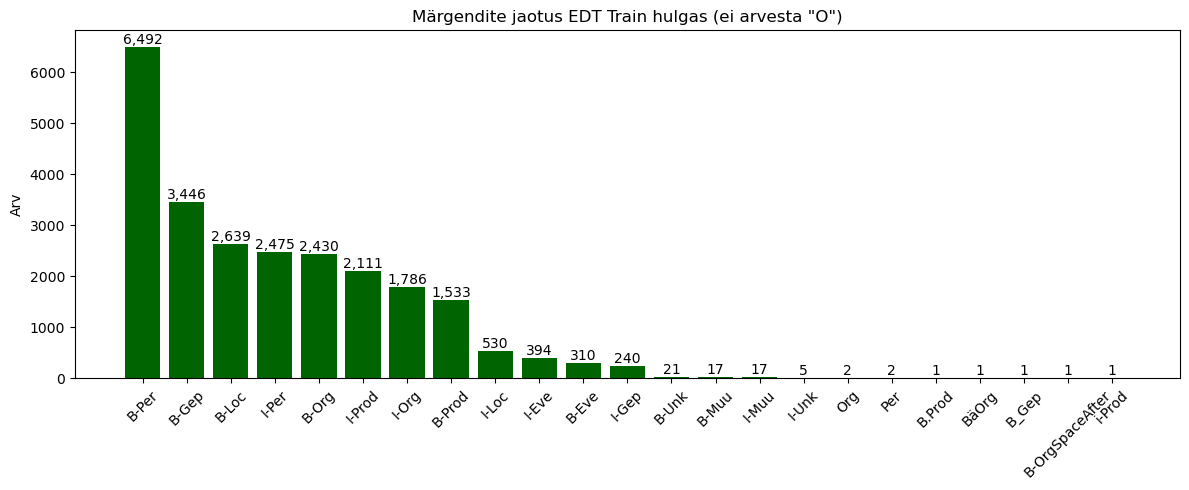

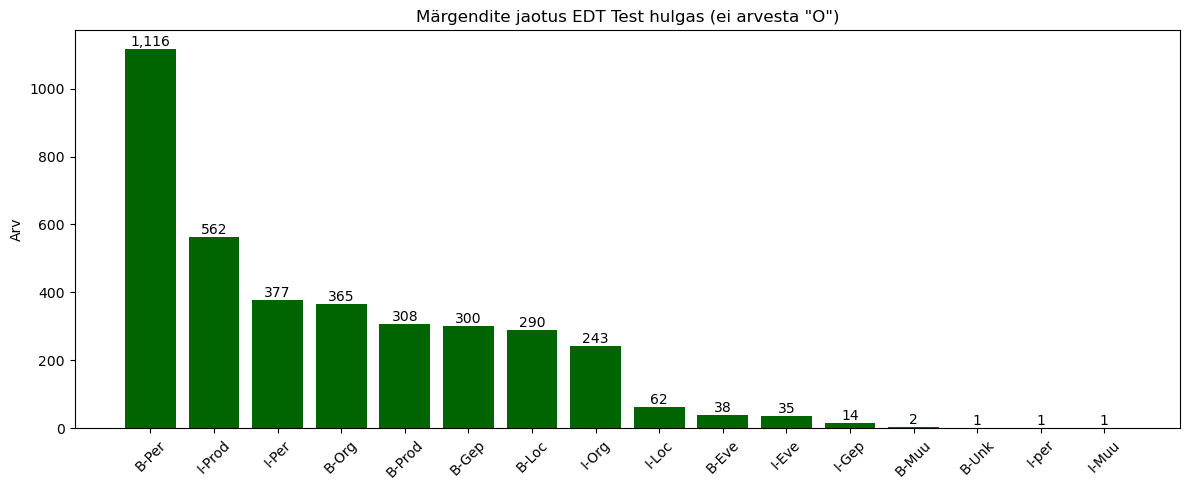

In [18]:
plot_tag_distribution_all_splits(edt_stats, 'EDT')

In [23]:
def dataset_stats_table(stats_dict):
    tags = ['Per', 'Org', 'Prod', 'Gep', 'Loc', 'Eve', 'Unk', 'Muu']
    tag_counts = defaultdict(lambda: defaultdict(int))
    
    for split, data in stats_dict.items():
        tag_counts[split]['word'] = data['words']
        tag_counts[split]['sent'] = data['sentences']
        
        for tag in tags:
            count = 0
            count += data.get(f'B-{tag}', 0)
            #count += data.get(f'I-{tag}', 0)
            
            tag_counts[split][tag] = count

    splits = list(stats_dict.keys())
    
    rows = []
    for stat in ['word', 'sent']:
        row_values = [str(tag_counts[split][stat]) for split in splits]
        if stat == 'sent':
            row = f'| {stat}\t| ' + '  | '.join(row_values) + '\t|'
        else:
            row = f'| {stat}\t| ' + ' | '.join(row_values) + ' |'
        rows.append(row)
        
    for tag in tags:
        row_values = [str(tag_counts[split][tag]) for split in splits]
        rows.append(f'| {tag}\t| ' + ' \t| '.join(row_values) + '\t|')
    header = '| \t| Dev\t| Train\t| Test\t|'
    table = '\n'.join([header]+rows)
    return table

In [24]:
print(dataset_stats_table(ewt_stats))

| 	| Dev	| Train	| Test	|
| word	| 10001 | 67431 | 13152 |
| sent	| 833  | 5444  | 913	|
| Per	| 235 	| 1226 	| 431	|
| Org	| 28 	| 206 	| 92	|
| Prod	| 157 	| 558 	| 105	|
| Gep	| 13 	| 264 	| 41	|
| Loc	| 5 	| 235 	| 28	|
| Eve	| 0 	| 29 	| 22	|
| Unk	| 1 	| 4 	| 0	|
| Muu	| 0 	| 9 	| 0	|


In [25]:
print(dataset_stats_table(edt_stats))

| 	| Dev	| Train	| Test	|
| word	| 44742 | 344581 | 48465 |
| sent	| 3122  | 24601  | 3207	|
| Per	| 837 	| 6492 	| 1116	|
| Org	| 215 	| 2430 	| 365	|
| Prod	| 245 	| 1533 	| 308	|
| Gep	| 295 	| 3446 	| 300	|
| Loc	| 377 	| 2639 	| 290	|
| Eve	| 38 	| 310 	| 38	|
| Unk	| 15 	| 21 	| 1	|
| Muu	| 6 	| 17 	| 2	|
